In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
original_width, original_height = 1996, 3072
target_width = 1024
target_height = int((original_height / original_width) * target_width)

print(target_width, target_height)

# 예를 들어, 계산된 target_height가 1331이면, 이미지 크기를 1024x1331로 조정합니다.


1024 1576


1/1 [==============================] - 0s 451ms/step
Prediction stats:
Min: 1.5737173e-08
Max: 0.99967504
Mean: 0.076923035
Classes found: [ 0  1  2  3  4  5  6  7  8  9 11]


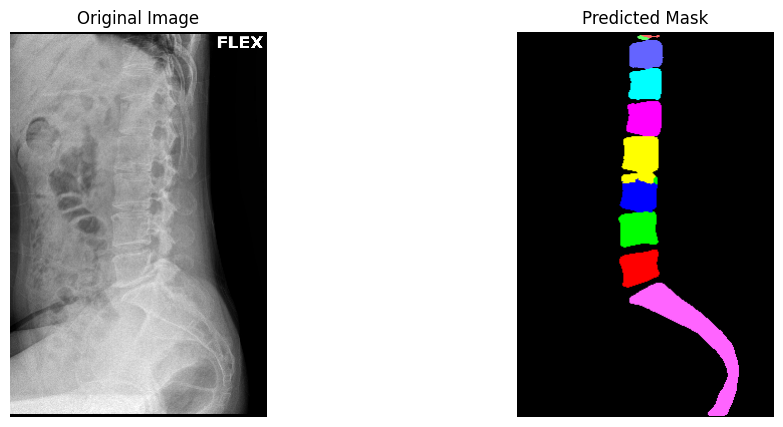

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 모델 및 이미지 경로 설정
model_path = r"/content/drive/MyDrive/006_BMS2/0002_latxray_training/dataset/non-aug/unet-non-aug.h5"  # 모델 파일 경로
test_image_path = r"/content/drive/MyDrive/006_BMS2/0002_latxray_training/dataset/non-aug/new/images/f00165953-221010.jpg"  # 테스트 이미지 파일 경로

# 모델 불러오기
model = load_model(model_path)

# 이미지 전처리 함수
def preprocess_image(image_path, target_size=(256, 384)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise FileNotFoundError(f"지정된 경로에 이미지 파일이 없습니다: {image_path}")
    image = cv2.resize(image, target_size)  # 이미지 크기를 모델의 입력 크기에 맞게 조정
    image = image / 255.0  # 이미지를 [0, 1] 범위로 정규화
    image = np.expand_dims(image, axis=0)  # 모델의 입력 형태에 맞추기 위해 차원 추가
    return image

# 예측 결과를 마스크 이미지로 변환하는 함수
def create_mask(prediction, class_colors):
    predicted_class = np.argmax(prediction, axis=-1)[0]
    mask = np.zeros((predicted_class.shape[0], predicted_class.shape[1], 3), dtype=np.uint8)
    for i in range(predicted_class.shape[0]):
        for j in range(predicted_class.shape[1]):
            mask[i, j, :] = class_colors[predicted_class[i, j]]
    return mask

# 클래스별 색상 정의 (RGB 순서로 정의)
class_colors = {
    0: (0, 0, 0),       # 배경색 (검정)
    1: (255, 0, 0),     # 클래스 1 색상 (빨간색)
    2: (0, 255, 0),  # L5
    3: (0, 0, 255),  # L4
    4: (255, 255, 0), # L3
    5: (255, 0, 255), # L2
    6: (0, 255, 255), # L1
    7: (100, 100, 255), # T12
    8: (100, 255, 100), # T11
    9: (255, 100, 100), # T10
    10: (100, 255, 255), # T9
    11: (255, 100, 255),
    12: (255, 255, 100),
    13: (100, 100, 100)
}

# 테스트 이미지 전처리
preprocessed_image = preprocess_image(test_image_path)

# 이미지 예측
prediction = model.predict(preprocessed_image)

# 예측 결과로부터 마스크 생성
mask = create_mask(prediction, class_colors)

# 모델의 예측 출력 검사
def inspect_model_output(prediction):
    print("Prediction stats:")
    print("Min:", np.min(prediction))
    print("Max:", np.max(prediction))
    print("Mean:", np.mean(prediction))
    print("Classes found:", np.unique(np.argmax(prediction, axis=-1)))

inspect_model_output(prediction)

# 원본 이미지와 예측된 마스크 시각화
original_image = cv2.imread(test_image_path)
original_image = cv2.resize(original_image, (256, 384))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
plt.imshow(mask)
plt.axis('off')

plt.show()
